In [1]:
%load_ext autoreload
%autoreload 1
%aimport mytorch

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import PIL.ImageOps
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torch_lr_finder import LRFinder

print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Scikit-learn:'.ljust(16), sklearn.__version__)
print('PyTorch:'.ljust(16), torch.__version__)
print('torchvision:'.ljust(16), torchvision.__version__)

Python:          3.10.8 (main, Oct 13 2022, 09:48:40) [Clang 14.0.0 (clang-1400.0.29.102)]
Scikit-learn:    1.2.0
PyTorch:         1.13.1
torchvision:     0.14.1


## Device

In [3]:
# Get cpu or gpu device for training
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE} device')

Using cpu device


## Hyperparameters & Constants

In [4]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 15  # select from: 2**n - 1 = [1, 3, 7, 15, ...]
SCHEDULER_GAMMA = 0.7

# Constants
CLASSES = 10
CHANNELS = 1
IMG_HEIGHT = 28
IMG_WIDTH = 28
DATA_PATH = './digit/data/'
MODEL_PATH = '../app/models/'
LABEL_MAP = {i: _class for i, _class in enumerate(datasets.MNIST.classes)}

# Actions
COMPUTE_NORM_PARAMS=False
DO_LR_RANGE_TEST=False

## Random state

In [5]:
RANDOM_STATE = 2147483647
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

## Show data

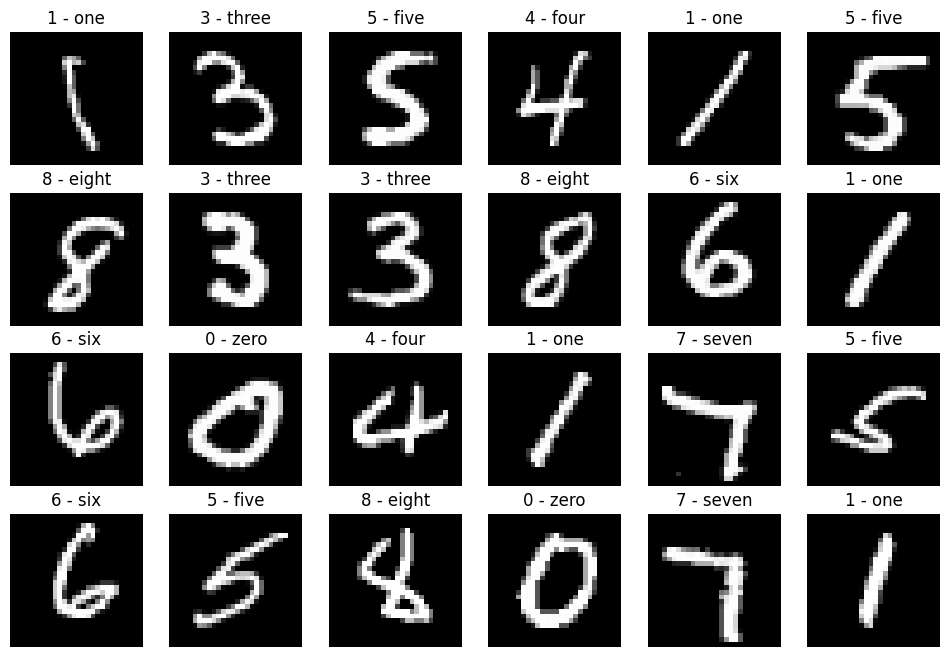

In [6]:
# Download training data from open datasets
data = datasets.MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
)

# Show sample
cols, rows = 6, 4
figure = plt.figure(figsize=(12, 8))
indexes = random.sample(range(len(data)), k=cols*rows)
for i, index in enumerate(indexes):
    image, label = data[index]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(LABEL_MAP[label])
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()
del data

## Prepare data
### Normalization parameters

In [7]:
if COMPUTE_NORM_PARAMS:
    # Download training data from open datasets
    data = datasets.MNIST(
        root=DATA_PATH,
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )

    data_mean, data_std = mytorch.get_mean_and_std(data, IMG_HEIGHT, IMG_WIDTH, CHANNELS, BATCH_SIZE)
    del data
else:
    data_mean, data_std = 0.13, 0.31

subzero = (0 - data_mean) / data_std  # for padding
print('mean & std:', data_mean, data_std)
print('subzero:', subzero)

mean & std: 0.13 0.31
subzero: -0.41935483870967744


### Transformation & Augmentation

In [8]:
training_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

### Datasets

In [9]:
training_dataset = datasets.MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=training_transform,
)

validation_dataset = datasets.MNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=validation_transform,
)

### Show augmented image

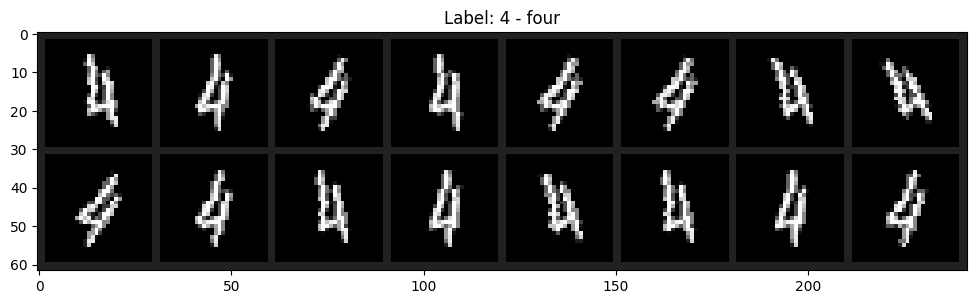

In [10]:
# index = 0
index = random.randint(0, len(training_dataset) - 1)

# Make a batch of images
images = []
for _ in range(BATCH_SIZE // 4):
    image, label = training_dataset[index]
    images.append(image)

# Make a grid from batch
X_grid = torchvision.utils.make_grid(images).permute(1, 2, 0).numpy()

# Unnormalize
X_grid = np.clip(data_std*X_grid + data_mean, 0, 1)

# Plot
figure = plt.figure(figsize=(12, 4))
plt.imshow(X_grid)
plt.title(f'Label: {LABEL_MAP[label]}');

### Dataloaders

In [11]:
# Create dataloaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Show shapes and types
print(f'Training samples:   {len(training_dataloader.dataset):>6d}')
print(f'Validation samples: {len(validation_dataloader.dataset):>6d}')
print()
print(f'Training batches:   {len(training_dataloader):>6d}')
print(f'Validation batches: {len(validation_dataloader):>6d}')
print()
X, y = next(iter(training_dataloader))
print(f'Shape of X [N, C, H, W]: {X.shape} {X.dtype}')
print(f'Shape of y             : {y.shape} {y.dtype}')
print()
# display(X[0])
# display(y[0])

Training samples:    60000
Validation samples:  10000

Training batches:      938
Validation batches:    157

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y             : torch.Size([64]) torch.int64



### Show a batch from training dataloader

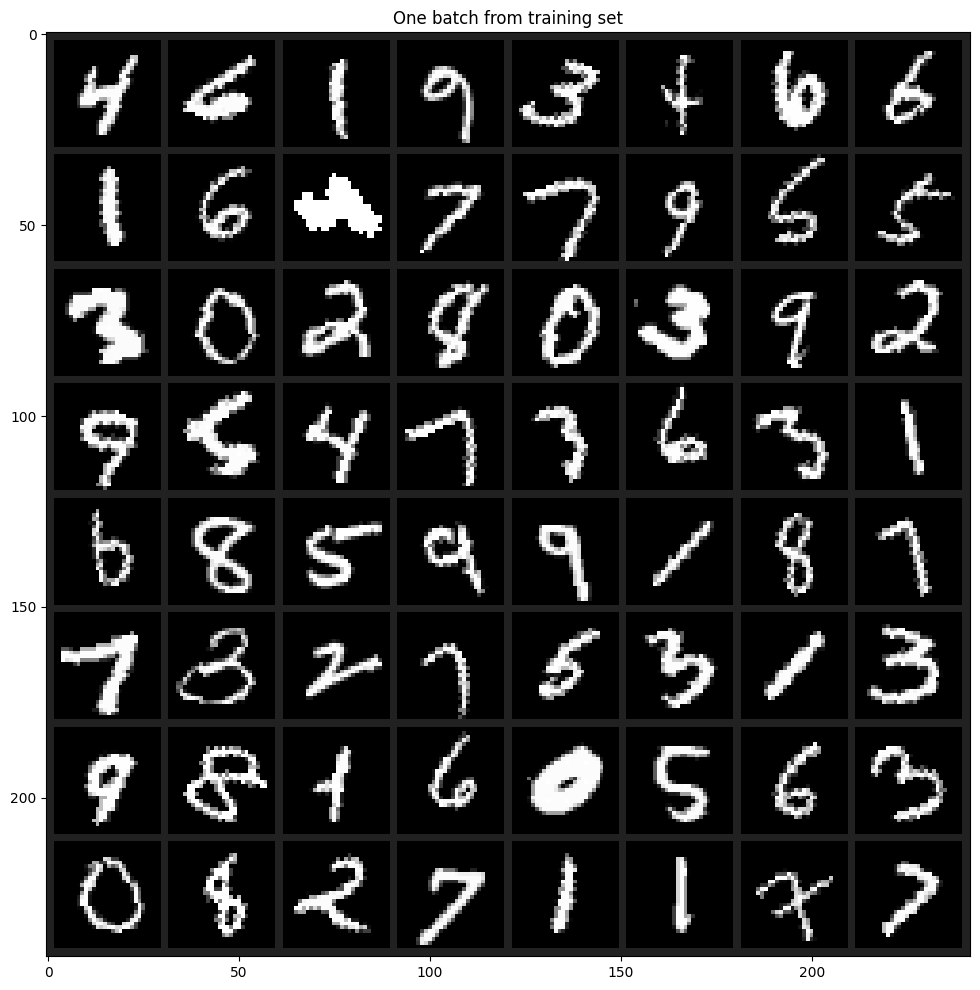

In [12]:
# Get a batch
X, _ = next(iter(training_dataloader))

# Make a grid from batch
X_grid = torchvision.utils.make_grid(X).permute(1, 2, 0).numpy()

# Unnormalize
X_grid = np.clip(data_std*X_grid + data_mean, 0, 1)

# Plot
figure = plt.figure(figsize=(12, 12))
plt.title('One batch from training set')
plt.imshow(X_grid);

### Show a batch from validation dataloader

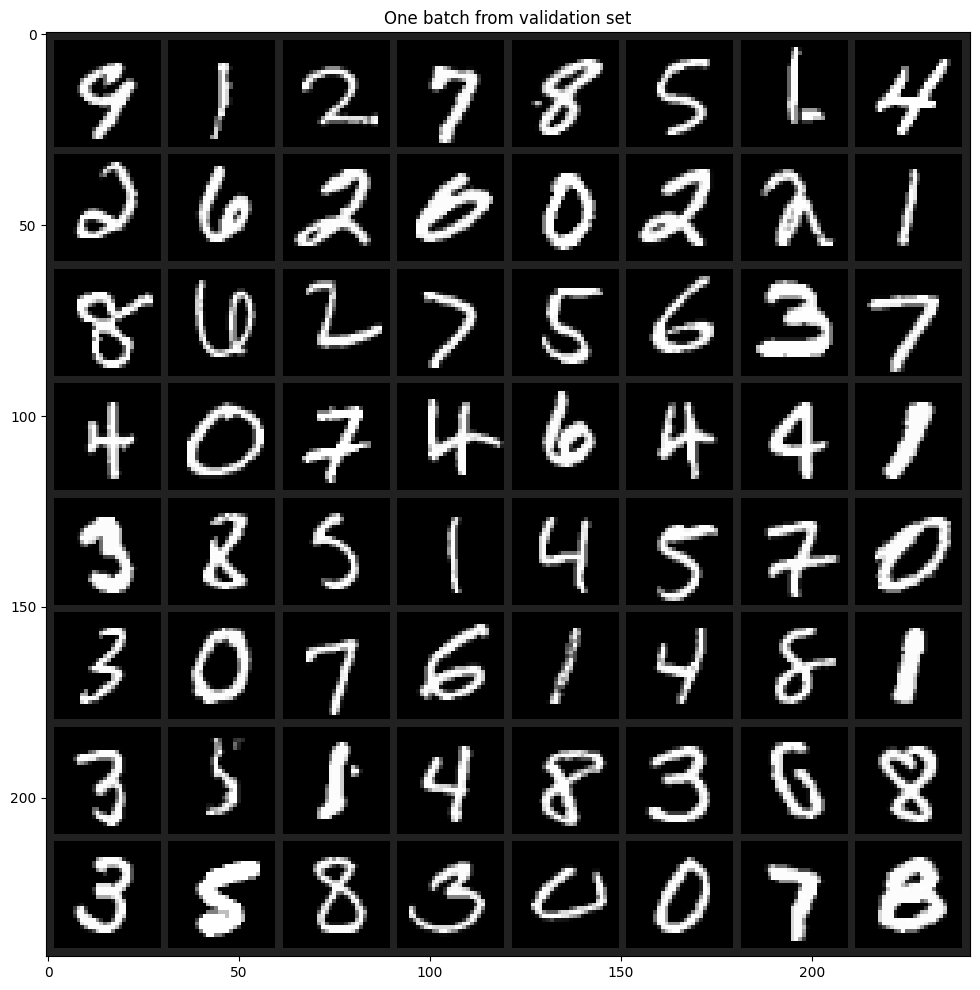

In [13]:
# Get a batch
X, _ = next(iter(validation_dataloader))

# Make a grid from batch
X_grid = torchvision.utils.make_grid(X).permute(1, 2, 0).numpy()

# Unnormalize
X_grid = np.clip(data_std*X_grid + data_mean, 0, 1)

# Plot
figure = plt.figure(figsize=(12, 12))
plt.title('One batch from validation set')
plt.imshow(X_grid);

## Computational graphs

In [14]:
# Dictionary of models
models = {}

In [15]:
class LogRegModel(nn.Module):
    """Logistic Regression model"""
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(IMG_HEIGHT*IMG_WIDTH, CLASSES)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

models['logreg'] = LogRegModel()

# Print model info
params = list(p.numel() for p in models['logreg'].parameters())
print('all params:      ', params)
print('total:', sum(params))
print()
params = list(p.numel() for p in models['logreg'].parameters() if p.requires_grad)
print('trainable params:', params)
print('total:', sum(params))
print()
print(models['logreg'])

all params:       [7840, 10]
total: 7850

trainable params: [7840, 10]
total: 7850

LogRegModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [16]:
class Dense3Model(nn.Module):
    """Dense model with 3 fully connected layers"""
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(IMG_HEIGHT*IMG_WIDTH, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, CLASSES)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

models['dense3'] = Dense3Model()

# Print model info
params = list(p.numel() for p in models['dense3'].parameters())
print('all params:      ', params)
print('total:', sum(params))
print()
params = list(p.numel() for p in models['dense3'].parameters() if p.requires_grad)
print('trainable params:', params)
print('total:', sum(params))
print()
print(models['dense3'])

all params:       [50176, 64, 4096, 64, 640, 10]
total: 55050

trainable params: [50176, 64, 4096, 64, 640, 10]
total: 55050

Dense3Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [17]:
class Conv3Model(nn.Module):
    """Convolutional model with 2 conv and 1 FC layers"""
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            # Conv 1 layer
            nn.ConstantPad2d(1, subzero),
            nn.Conv2d(CHANNELS, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(4),
            
            # Conv 2 layer
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64*7*7, CLASSES)

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

models['conv3'] = Conv3Model()

# Print model info
params = list(p.numel() for p in models['conv3'].parameters())
print('all params:      ', params)
print('total:', sum(params))
print()
params = list(p.numel() for p in models['conv3'].parameters() if p.requires_grad)
print('trainable params:', params)
print('total:', sum(params))
print()
print(models['conv3'])

all params:       [288, 32, 18432, 64, 31360, 10]
total: 50186

trainable params: [288, 32, 18432, 64, 31360, 10]
total: 50186

Conv3Model(
  (conv_stack): Sequential(
    (0): ConstantPad2d(padding=(1, 1, 1, 1), value=-0.41935483870967744)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=3136, out_features=10, bias=True)
)


In [18]:
class Conv5Model(nn.Module):
    """Convolutional model with 4 conv and 1 FC layers"""
    def __init__(self, ch=(8, 16, 32, 64)):
        super().__init__()
        self.conv_stack = nn.Sequential(
            # Conv 1 layer
            nn.ConstantPad2d(1, subzero),
            nn.Conv2d(CHANNELS, ch[0], 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Conv 2 layer
            nn.Conv2d(ch[0], ch[1], 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Conv 3 layer
            nn.Conv2d(ch[1], ch[2], 3, padding=1),
            nn.ReLU(),
            nn.ConstantPad2d((0, 1, 0, 1), 0),
            nn.MaxPool2d(2),
            
            # Conv 4 layer
            nn.Conv2d(ch[2], ch[3], 4),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(ch[3], CLASSES)

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

models['conv5'] = Conv5Model((32, 32, 32, 64))

# Print model info
params = list(p.numel() for p in models['conv5'].parameters())
print('all params:      ', params)
print('total:', sum(params))
print()
params = list(p.numel() for p in models['conv5'].parameters() if p.requires_grad)
print('trainable params:', params)
print('total:', sum(params))
print()
print(models['conv5'])

all params:       [288, 32, 9216, 32, 9216, 32, 32768, 64, 640, 10]
total: 52298

trainable params: [288, 32, 9216, 32, 9216, 32, 32768, 64, 640, 10]
total: 52298

Conv5Model(
  (conv_stack): Sequential(
    (0): ConstantPad2d(padding=(1, 1, 1, 1), value=-0.41935483870967744)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (12): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64

## Range test for learning rate

In [19]:
if DO_LR_RANGE_TEST:
    start_lr = 1e-4
    end_lr = 1e1
    num_iter = 50

    # Loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    for name, model in models.items():
        print(name)
        
        # Optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=start_lr)

        # Range test for LR
        lr_finder = LRFinder(model, optimizer, loss_fn)
        lr_finder.range_test(train_loader=training_dataloader,
                             val_loader=validation_dataloader,
                             end_lr=end_lr,
                             num_iter=num_iter)
        
        # Inspect the loss-LR graph
        lr_finder.plot()
        
        # Reset the model and optimizer to their initial state
        lr_finder.reset()
else:
    lrs = {
        'logreg': 1e-1,
        'dense3': 6e-1,
        'conv3': 1e-1,
        'conv5': 4e-1,
    }

## Loss function & Optimizer & Scheduler & Writer

In [20]:
wrapped_models = {}
for name in models:
    # Loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.SGD(models[name].parameters(), lr=lrs[name])

    # LR scheduler
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
    if isinstance(scheduler, CosineAnnealingWarmRestarts):
        # For CosineAnnealingWarmRestarts only
        scheduler.gamma = SCHEDULER_GAMMA

    # Writer
    writer = SummaryWriter(comment=f'_{name}_b{BATCH_SIZE}_e{EPOCHS}_g{SCHEDULER_GAMMA}')

    # Wrap the model
    wrapped_models[name] = mytorch.WrappedNN(
        models[name],
        loss_fn,
        optimizer,
        scheduler,
        writer,
        DEVICE,
    )

wrapped_models

Using cpu device
Using cpu device
Using cpu device
Using cpu device


{'logreg': <mytorch.WrappedNN at 0x168e030d0>,
 'dense3': <mytorch.WrappedNN at 0x168e03cd0>,
 'conv3': <mytorch.WrappedNN at 0x168e025f0>,
 'conv5': <mytorch.WrappedNN at 0x168e02ef0>}

## Training

In [21]:
for name, model in wrapped_models.items():
    print()
    print('Start', name, 'model')
    
    # Train model
    model.train(training_dataloader, validation_dataloader, EPOCHS)


Start logreg model


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 403.52it/s, accuracy=0.901800, loss=0.337733]


Training complete in 0m 59s

Start dense3 model


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 391.60it/s, accuracy=0.973500, loss=0.085568]


Training complete in 0m 58s

Start conv3 model


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 131.61it/s, accuracy=0.990400, loss=0.030720]


Training complete in 4m 47s

Start conv5 model


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.12it/s, accuracy=0.993400, loss=0.021898]


Training complete in 7m 58s


### TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir digit/runs

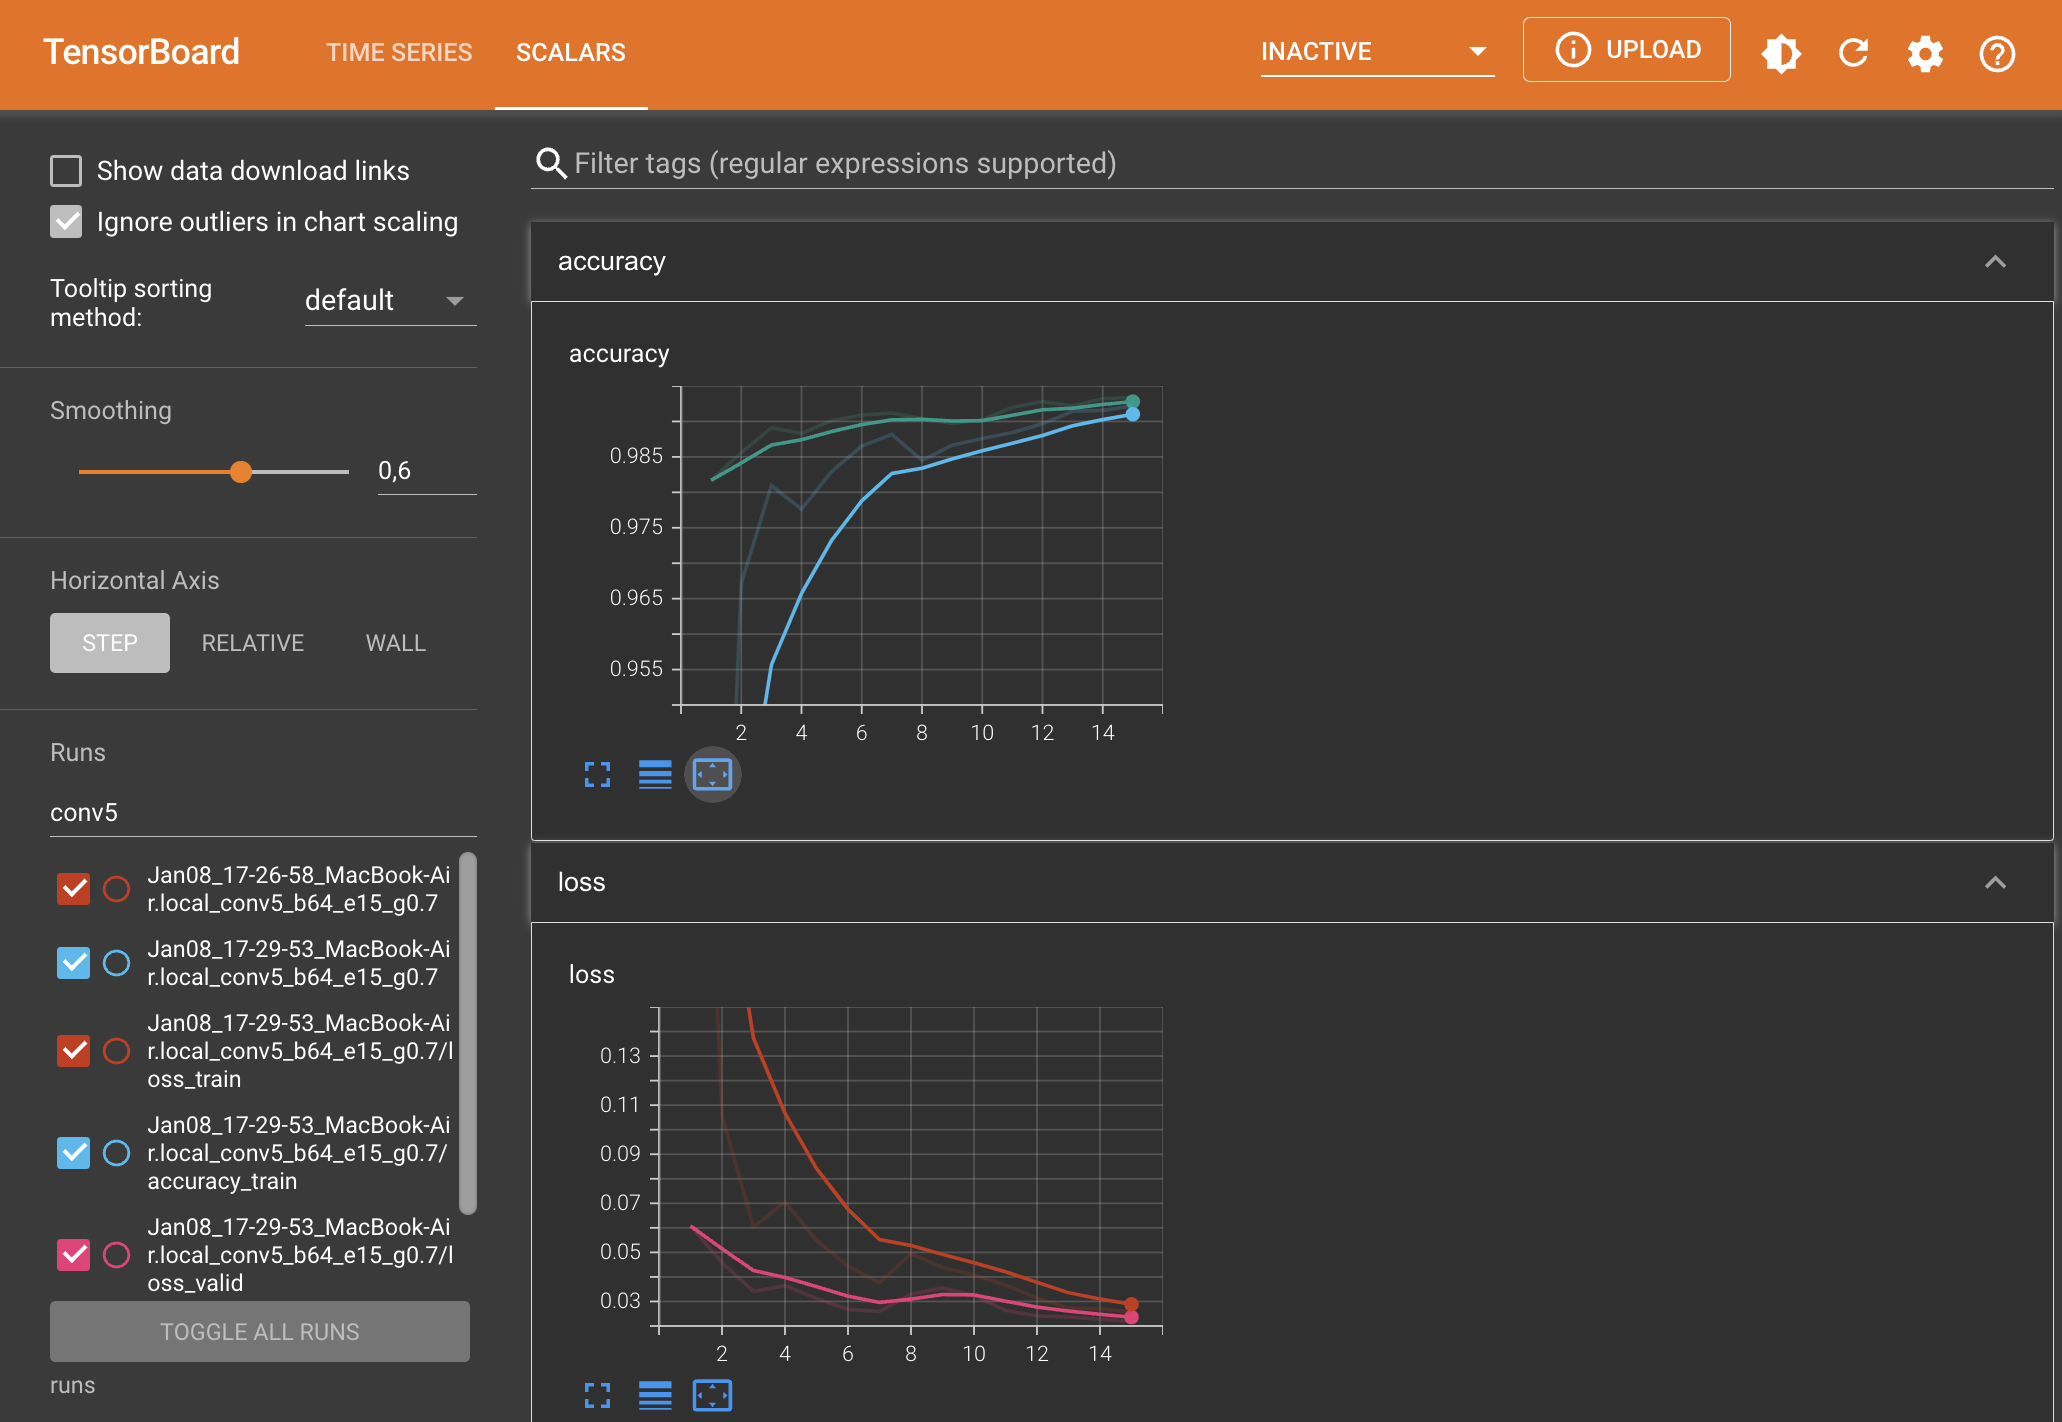

### Learning rate history

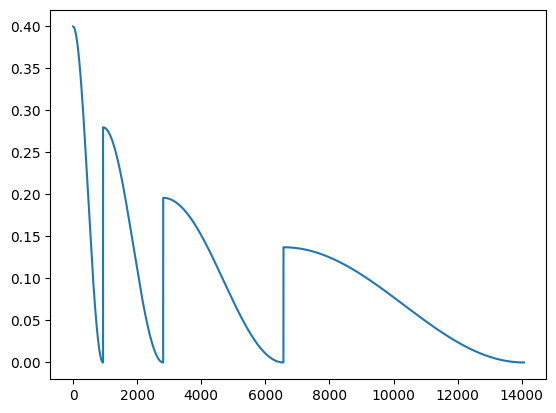

In [23]:
pd.Series(wrapped_models['conv5'].lr_history).plot();

## Confusion matrix
### for the best model

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 113.67it/s]


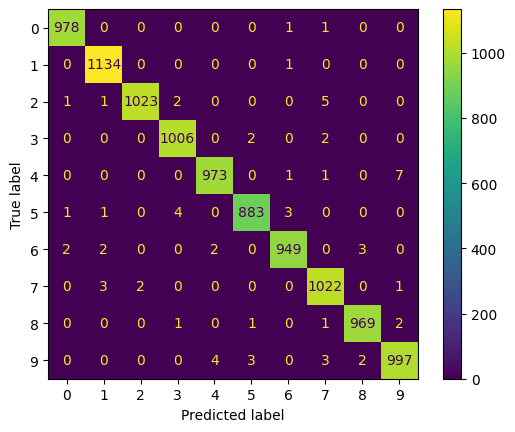

In [24]:
# Split X and y
X_valid, y_valid = mytorch.split_xy_dataset(validation_dataset)

# Compute predictions
y_valid_pred = wrapped_models['conv5'].predict(X_valid)

# Show confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

## Errors
### for the best model

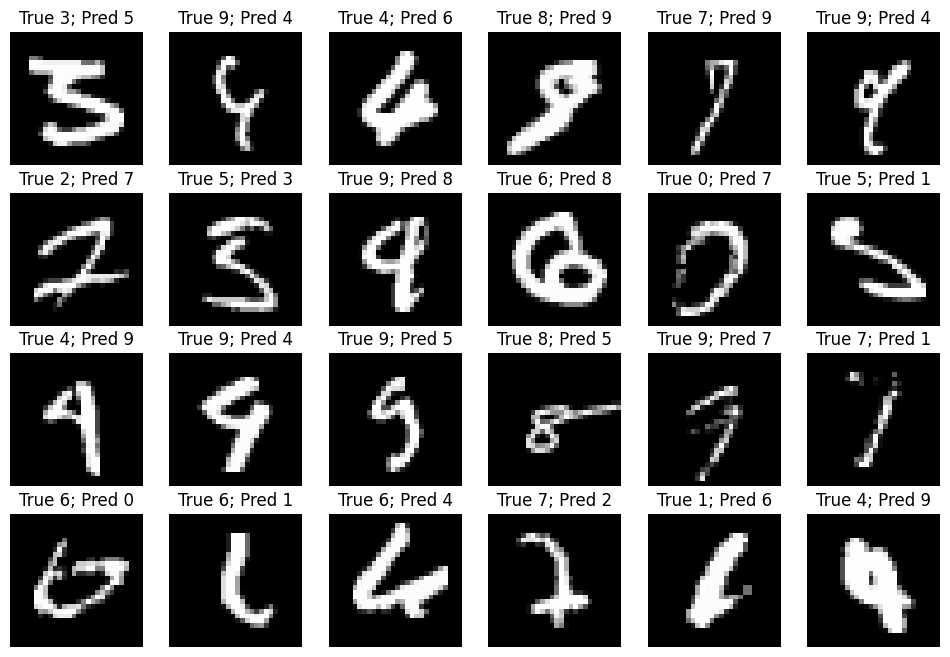

In [25]:
# Find examples with errors
err_mask = y_valid != y_valid_pred
err_indexes = err_mask.nonzero().squeeze().tolist()

# Show examples
cols, rows = 6, 4
figure = plt.figure(figsize=(12, 8))
indexes = random.sample(err_indexes, k=cols*rows)
for i, index in enumerate(indexes):
    image = X_valid[index].permute(1, 2, 0).numpy()
    image = np.clip(data_std*image + data_mean, 0, 1)  # Unnormalize
    true_label, pred_label = y_valid[index].item(), y_valid_pred[index].item()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'True {int(true_label)}; Pred {pred_label}')
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()

## Save models

In [26]:
for name, model in wrapped_models.items():
    torch.save(model.model.state_dict(), MODEL_PATH + 'digit_' + name + '.pt')
    print(f'"{name}" model has been saved')

"logreg" model has been saved
"dense3" model has been saved
"conv3" model has been saved
"conv5" model has been saved


## Load model and predict

In [27]:
def preprocess_image(pil_image, from_dataset=True):
    if not from_dataset:
        # Remove alpha channel, convert to grayscale, resize, invert
        background = Image.new('RGBA', pil_image.size, (255, 255, 255, 255))
        pil_image = Image.alpha_composite(background, pil_image)
        pil_image = pil_image.convert('L')
        pil_image = pil_image.resize((IMG_WIDTH, IMG_HEIGHT))
        pil_image = PIL.ImageOps.invert(pil_image)

    # Transform to Tensor, normalize, add dimension
    data_mean, data_std = 0.13, 0.31
    X = torchvision.transforms.functional.to_tensor(pil_image)
    X = (X - data_mean) / data_std
    X = torch.unsqueeze(X, dim=0)
    
    return X

In [28]:
from_dataset = False

# Load image
if from_dataset:
    X_example, y_example = datasets.MNIST(
        root=DATA_PATH,
        train=False,
        download=True,
    )[0]
else:
    X_example = Image.open('../image.png')
    y_example = 2

# Preprocess image
X_example = preprocess_image(X_example, from_dataset=from_dataset)

# Load model
model = Conv5Model((32, 32, 32, 64))
model.load_state_dict(torch.load(MODEL_PATH + 'digit_conv5.pt'))

# Predict
model.eval()
with torch.no_grad():
    probas = nn.Softmax(dim=1)(model(X_example))[0]
    max_proba = probas.max().item()
    prediction = probas.argmax().item()
    prediction_label = LABEL_MAP[prediction]
    actual_label = LABEL_MAP[y_example]

print('image shape:    ', list(X_example.shape))
print('image min & max:', [X_example.min().item(), X_example.max().item()])
print()
print(f'Probabilities: {[float("%.02e" % x) for x in probas.tolist()]}')
print()
print(f'Predicted: "{prediction_label}", Actual: "{actual_label}"')

image shape:     [1, 1, 28, 28]
image min & max: [-0.4193548262119293, 2.8064515590667725]

Probabilities: [7.46e-09, 2.04e-09, 1.0, 1.87e-09, 3.94e-09, 1.28e-10, 1.29e-11, 3.99e-08, 7.64e-08, 1.27e-08]

Predicted: "2 - two", Actual: "2 - two"
